In [1]:
import numpy as np
from scipy.linalg import cholesky, cho_solve, solve_triangular

class MultiGPR:
    def __init__(self, kernel="SM", noise=1e-4):
        """
        Initialize GPR model
        """
        self.kernel = kernel
        self.noise = noise

    def spectral_mixture_kernel(self, X1, X2, weights, means, scales):
        """
        Compute the Spectral Mixture (SM) Kernel
        """
        K = np.zeros((X1.shape[0], X2.shape[0]))
        for i in range(len(weights)):
            w, m, s = weights[i], means[i], scales[i]
            K += w * np.exp(-2 * np.pi ** 2 * s ** 2 * (X1[:, None] - X2[None, :]) ** 2) \
                 * np.cos(2 * np.pi * m * (X1[:, None] - X2[None, :]))
        return K
    
    def rbf_kernel(self, X1, X2, sigma):
        """
        Compute the RBF Kernel
        """
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return np.exp(-0.5 * sqdist / sigma**2)

    def train(self, X_train, Y_train, weights=[1.0], means=[1.0], scales=[1.0]):
        """
        Train the GPR model
        """
        self.X_train = X_train
        self.Y_train = Y_train

        if self.kernel == "SM":
            K = self.spectral_mixture_kernel(X_train, X_train, weights, means, scales)
        else:
            raise ValueError("Invalid kernel")

        K += self.noise * np.eye(K.shape[0])
        self.L = cholesky(K, lower=True)
        self.alpha = cho_solve((self.L, True), self.Y_train)

    def predict(self, X_test, weights=[1.0], means=[1.0], scales=[1.0]):
        """
        Make a prediction
        """
        if self.kernel == "SM":
            K_star = self.spectral_mixture_kernel(self.X_train, X_test, weights, means, scales)
            K_star_star = self.spectral_mixture_kernel(X_test, X_test, weights, means, scales)
        else:
            raise ValueError("Invalid kernel")

        mu = K_star.T.dot(self.alpha)
        v = solve_triangular(self.L, K_star, lower=True)
        var = K_star_star - v.T.dot(v)

        return mu, var

In [2]:
gpr = MultiGPR(kernel="SM")

# Train on some data (for demonstration, using 1D numpy arrays)
X_train = np.array([1.0, 2.0, 3.0])
Y_train = np.array([2.0, 4.0, 3.0])
gpr.train(X_train, Y_train)

# Make a prediction
X_test = np.array([1.5, 2.5])
mu, var = gpr.predict(X_test)

In [3]:
mu

array([-0.04314699, -0.05033815])

In [21]:
import matplotlib.pyplot as plt

# Generate training and testing data
np.random.seed(42)
X_train = np.sort(np.random.uniform(0, 10, 30))
Y_train = np.sin(X_train) + 0.1 * np.random.randn(30)  # Adding some noise

X_test = np.linspace(0, 10, 500)

In [22]:
# Initialize and train GPR model
gpr = MultiGPR(kernel="SM")
gpr.train(X_train, Y_train, weights=[1.0, 1.0], means=[1.0, 0.5], scales=[0.1, 0.2])

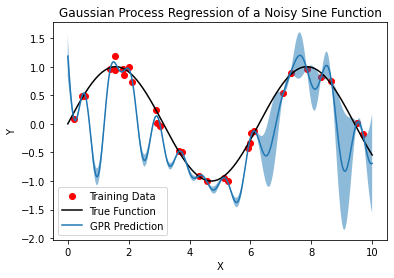

In [23]:
# Make predictions
mu, var = gpr.predict(X_test, weights=[1.0, 1.0], means=[1.0, 0.5], scales=[0.1, 0.2])

# Visualization
plt.figure()
plt.scatter(X_train, Y_train, c='r', label='Training Data')
plt.plot(X_test, np.sin(X_test), 'k-', label='True Function')
plt.plot(X_test, mu, label='GPR Prediction')
plt.fill_between(X_test, mu - np.sqrt(np.diag(var)), mu + np.sqrt(np.diag(var)), alpha=0.5)
plt.title("Gaussian Process Regression of a Noisy Sine Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()